In [1]:
import os
import json
from itertools import chain

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity, CreateFromBitString
from mordred import Calculator, descriptors
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

Declare constants.

In [2]:
ROOT = '.'
DATA_FOLDER = f'{ROOT}/data'
OUT_FOLDER = f'{ROOT}/results' 
FILE = f"{DATA_FOLDER}/Supp. File 1.xlsx"
ENDPOINT = 'binaryDILI'

Read input data.

In [3]:
labels = pd.read_excel(FILE, sheet_name='Original Dataset Labels', 
                       usecols=['InChIKey', 'binaryDILI'],  engine='openpyxl')

In [4]:
names = pd.read_excel(FILE, sheet_name='Original Dataset BioDescs',
                      usecols=['InChIKey', 'Name'], engine='openpyxl')

Prepare molecular descriptors

In [5]:
data_mol = pd.read_excel(FILE, sheet_name='Original Dataset MolDescs',
                         usecols=['InChIKey', 'SMILES'], engine='openpyxl')

In [6]:
data_mol = names.merge(labels, on='InChIKey').merge(data_mol, on='InChIKey')

In [7]:
molecules = [Chem.MolFromSmiles(x) for x in data_mol['SMILES']]

In [8]:
data_moldescs = Calculator(descriptors, ignore_3D=True).pandas(molecules)
data_moldescs = pd.DataFrame(data_moldescs)

  0%|          | 0/117 [00:00<?, ?it/s]

C:\Users\ojbeq\.conda\envs\DILInegOS\Lib\site-packages\mordred\_base\pandas_module.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t[t.applymap(is_missing)] = value


In [9]:
data_moldescs.insert(0, 'DILI', data_mol['binaryDILI'])

In [10]:
data_moldescs.replace('nan', np.nan, inplace=True)
data_moldescs.dropna(axis=1, inplace=True)

In [11]:
assert not np.any(data_moldescs.isna())
assert not np.any(data_moldescs.isnull())

In [12]:
data_moldescs

,DILI,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,1,33.79,26.701,0,1,55.609,2.484,4.968,55.609,1.264,...,10.887,82.039,645.248,7.417,7413,86,234,285,18.722,9.778
1,1,8.106,7.427,0,0,13.222,2.22,4.44,13.222,1.202,...,8.795,40.344,151.063,7.553,166,11,50,53,4.583,2.5
2,1,13.9,11.934,2,0,21.953,2.429,4.728,21.953,1.22,...,9.692,64.869,273.063,9.102,682,23,92,104,6.757,3.875
3,1,7.807,7.344,0,0,13.098,2.37,4.634,13.098,1.31,...,9.161,53.745,136.039,9.717,105,12,52,61,2.833,2.222
4,1,23.38,19.008,0,1,39.599,2.504,4.916,39.599,1.277,...,10.292,80.945,645.024,10.75,2897,50,156,184,10.861,7.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1,24.166,19.979,0,1,41.742,2.454,4.908,41.742,1.265,...,10.337,68.825,454.283,6.398,3698,55,160,187,12.951,7.889
113,1,17.873,14.858,0,0,29.447,2.482,4.964,29.447,1.28,...,10.123,57.518,308.105,7.9,1092,38,120,142,7.639,5.083
114,1,25.651,20.327,0,3,42.76,2.447,4.895,42.76,1.258,...,10.36,70.097,473.264,6.859,4012,50,168,194,11.611,7.833
115,1,32.271,24.321,0,0,52.211,2.482,4.898,52.211,1.273,...,10.665,94.231,575.209,7.773,6548,66,220,260,13.507,8.875


In [13]:
pca_mol = make_pipeline(MinMaxScaler(),
                        PCA(n_components=2, svd_solver='full', random_state=1234))
data_moldescs_pca = pd.concat([data_mol.loc[:, ['Name', 'binaryDILI']], 
                               pd.DataFrame(pca_mol.fit_transform(data_moldescs.drop(columns=['DILI'])),
                                            columns=['PC1', 'PC2'])],
                              axis=1)

In [14]:
loadings = pd.DataFrame(pca_mol.named_steps["pca"].components_.T, columns=['PC1', 'PC2'], index=data_moldescs.columns[1:])
loadings['PC1 sign'] = loadings['PC1'].apply(np.sign).map({1: '+', -1: '-'})
loadings['PC2 sign'] = loadings['PC2'].apply(np.sign).map({1: '+', -1: '-'})

In [15]:
loadings.loc[[x is np.nan for x in loadings['PC1 sign']], 'PC1 sign'] = ''
loadings.loc[[x is np.nan for x in loadings['PC2 sign']], 'PC2 sign'] = ''

In [16]:
loadings.apply(lambda x: np.abs(x) if 'sign' not in x.name else x).sort_values(by='PC1', ascending=False).head(3)

,PC1,PC2,PC1 sign,PC2 sign
Lipinski,0.073655,0.032690,-,-
piPC10,0.060297,0.093377,+,-
ATS5dv,0.060254,0.001360,+,-


In [17]:
loadings.apply(lambda x: np.abs(x) if 'sign' not in x.name else x).sort_values(by='PC2', ascending=False).head(3)

,PC1,PC2,PC1 sign,PC2 sign
MAXaaCH,0.002192,0.121894,-,-
MINaaCH,0.004584,0.114825,-,-
ETA_dEpsilon_B,0.000969,0.108537,-,-


In [18]:
data_moldescs_pca[data_moldescs_pca['PC1'] > 9]

,Name,binaryDILI,PC1,PC2
34,DIGOXIN,0,12.045044,4.351082
43,ERYTHROMYCIN,1,10.135743,4.886260
102,TACROLIMUS,1,11.287492,4.110363


In [19]:
data_moldescs_pca[data_moldescs_pca['PC2'] < -3]

,Name,binaryDILI,PC1,PC2
7,AZATHIOPRINE,1,-0.978296,-4.139114
8,BENZBROMARONE,1,0.313727,-3.476099
67,MEBENDAZOLE,1,-0.265324,-3.179610


In [20]:
pd.concat([data_mol.loc[data_moldescs[data_moldescs['SLogP'] < -4].index, 'Name'], data_moldescs.loc[data_moldescs['SLogP'] < -4, 'SLogP']], axis=1)

,Name,SLogP
0,ACARBOSE,-8.564
63,KANAMYCIN,-7.291
80,NEOMYCIN,-8.895


In [21]:
pd.concat([data_mol.loc[data_moldescs[data_moldescs['SLogP'] > 6].index, 'Name'], data_moldescs.loc[data_moldescs['SLogP'] > 6, 'SLogP']], axis=1)

,Name,SLogP
4,AMIODARONE,6.936


In [22]:
loadings_corr = pd.DataFrame(pca_mol.named_steps["pca"].components_.T * np.sqrt(pca_mol.named_steps["pca"].explained_variance_), columns=['PC1', 'PC2'], index=data_moldescs.columns[1:])
loadings_corr.apply(np.abs).sort_values(by='PC1', ascending=False).head(3)

,PC1,PC2
Lipinski,0.258291,0.064575
piPC10,0.211448,0.184459
ATS5dv,0.211298,0.002686


In [23]:
loadings_corr.apply(np.abs).sort_values(by='PC2', ascending=False).head(3)

,PC1,PC2
MAXaaCH,0.007687,0.240792
MINaaCH,0.016075,0.226827
ETA_dEpsilon_B,0.003397,0.214404


In [24]:
tsne_mol = make_pipeline(MinMaxScaler(),
                         TSNE(n_components=2, random_state=1234))
data_moldescs_tsne = pd.concat([data_mol.loc[:, ['Name', 'binaryDILI']],
                                pd.DataFrame(tsne_mol.fit_transform(data_moldescs.drop(columns=['DILI'])),
                                             columns=['t-SNE 1', 't-SNE 2'])],
                               axis=1)

In [25]:
data_moldescs_tsne[(data_moldescs_tsne['t-SNE 1'] < -9) & (data_moldescs_tsne['t-SNE 2'] < -2)]

,Name,binaryDILI,t-SNE 1,t-SNE 2


In [26]:
data_moldescs_tsne[(data_moldescs_tsne['t-SNE 1'] < -9) & (data_moldescs_tsne['t-SNE 2'] > -2)]

,Name,binaryDILI,t-SNE 1,t-SNE 2
0,ACARBOSE,1,-9.572124,1.115563
34,DIGOXIN,0,-9.322291,2.726203
43,ERYTHROMYCIN,1,-9.701863,2.623166
63,KANAMYCIN,0,-9.519159,0.791166
80,NEOMYCIN,0,-9.553255,0.965224
102,TACROLIMUS,1,-9.682076,2.746436


Prepare Biological descriptors

In [27]:
data_molbio = pd.read_excel(FILE, sheet_name='Original Dataset BioDescs',
                            engine='openpyxl')
data_molbio.drop(columns=['SMILES', 'Inclusion', 'CMAX_uM'],
                inplace=True)
data_molbio = labels.merge(data_molbio, on='InChIKey')

In [28]:
data_molbio

,InChIKey,binaryDILI,Name,bip_cmax1_tp24_NormCellCounts,bip_cmax1_tp24_DmsoMeanCellCounts,bip_cmax1_tp24_GfpPos4i,bip_cmax1_tp24_GfpPos3i,bip_cmax1_tp24_GfpPos2i,bip_cmax1_tp24_GfpPos1i,bip_cmax1_tp24_DmsoIntegratedIntensityPlateLognorm,...,srxn1_cmax100_tp72_GfpPos4i,srxn1_cmax100_tp72_GfpPos3i,srxn1_cmax100_tp72_GfpPos2i,srxn1_cmax100_tp72_GfpPos1i,srxn1_cmax100_tp72_DmsoIntegratedIntensityPlateLognorm,srxn1_cmax100_tp72_CytoplasmNucleiIntegratedIntensityImageGfp,srxn1_cmax100_tp72_CytoplasmNucleiMeanIntensityImageGfp,srxn1_cmax100_tp72_AnnexinPos,srxn1_cmax100_tp72_PiPos,srxn1_cmax100_tp72_ImageCountParentObj
0,XUFXOAAUWZOOIT-UHFFFAOYSA-N,1,ACARBOSE,1.005890,441.649083,0.023958,0.054329,0.114779,0.267759,0.975843,...,0.003452,0.007002,0.028261,0.398427,1.415914,2.215023,0.020010,0.016037,0.022594,1293.576746
1,RZVAJINKPMORJF-UHFFFAOYSA-N,1,ACETAMINOPHEN,1.119263,441.649083,0.038564,0.072146,0.120781,0.293125,0.975843,...,0.005574,0.019859,0.055612,0.369490,1.415914,2.081121,0.024075,0.020104,0.027622,1085.098562
2,SUPKOOSCJHTBAH-UHFFFAOYSA-N,1,ADEFOVIR,1.084936,441.649083,0.030673,0.061210,0.143102,0.317844,0.975843,...,0.006213,0.012540,0.026656,0.309645,1.415914,1.581463,0.021511,0.025530,0.029637,1258.533427
3,OFCNXPDARWKPPY-UHFFFAOYSA-N,1,ALLOPURINOL,1.063440,441.649083,0.052244,0.092165,0.151847,0.311346,0.975843,...,0.078540,0.254188,0.686016,0.915955,1.415914,17.957425,0.142973,0.080726,0.049700,1141.177231
4,IYIKLHRQXLHMJQ-UHFFFAOYSA-N,1,AMIODARONE,1.250388,441.649083,0.039340,0.072926,0.151620,0.344543,0.975843,...,0.003492,0.006609,0.018493,0.408257,1.415914,2.035757,0.020899,0.015243,0.012384,1322.096362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,SGTNSNPWRIOYBX-UHFFFAOYSA-N,1,VERAPAMIL,1.206362,441.649083,0.036182,0.071394,0.124938,0.342827,0.975843,...,0.016949,0.034802,0.105192,0.619893,1.415914,3.470267,0.037573,0.012220,0.012311,1365.185575
113,QTXVAVXCBMYBJW-UHFFFAOYSA-N,1,WARFARIN,1.299619,441.649083,0.041045,0.083805,0.194050,0.382466,0.975843,...,0.003980,0.013108,0.055261,0.621565,1.415914,3.130244,0.026075,0.025065,0.012576,1068.677130
114,ZXIBCJHYVWYIKI-PZJWPPBQSA-N,1,XIMELAGATRAN,1.137147,441.649083,0.030818,0.053513,0.106229,0.297403,0.975843,...,0.001481,0.003533,0.028220,0.486162,1.415914,2.374940,0.022355,0.016514,0.014641,1340.171369
115,YEEZWCHGZNKEEK-UHFFFAOYSA-N,1,ZAFIRLUKAST,1.115027,441.649083,0.040540,0.074680,0.144375,0.315214,0.975843,...,0.004359,0.013153,0.037412,0.459173,1.415914,2.314197,0.025387,0.029373,0.027202,1244.111837


In [29]:
pca_bio = make_pipeline(SimpleImputer(),
                        MinMaxScaler(),
                        PCA(n_components=2, svd_solver='full', random_state=1234))
data_molbio_pca = pd.concat([data_molbio.loc[:, ['Name', 'binaryDILI']],
                             pd.DataFrame(pca_bio.fit_transform(data_molbio.drop(columns=['InChIKey', 'binaryDILI', 'Name'])),
                                          columns=['PC1', 'PC2'])],
                            axis=1)
tsne_bio = make_pipeline(SimpleImputer(),
                         MinMaxScaler(),
                         TSNE(n_components=2, random_state=1234))
data_molbio_tsne = pd.concat([data_molbio.loc[:, ['Name', 'binaryDILI']],
                              pd.DataFrame(tsne_bio.fit_transform(data_molbio.drop(columns=['InChIKey', 'binaryDILI', 'Name'])),
                                           columns=['t-SNE 1', 't-SNE 2'])],
                             axis=1)

Plot data.

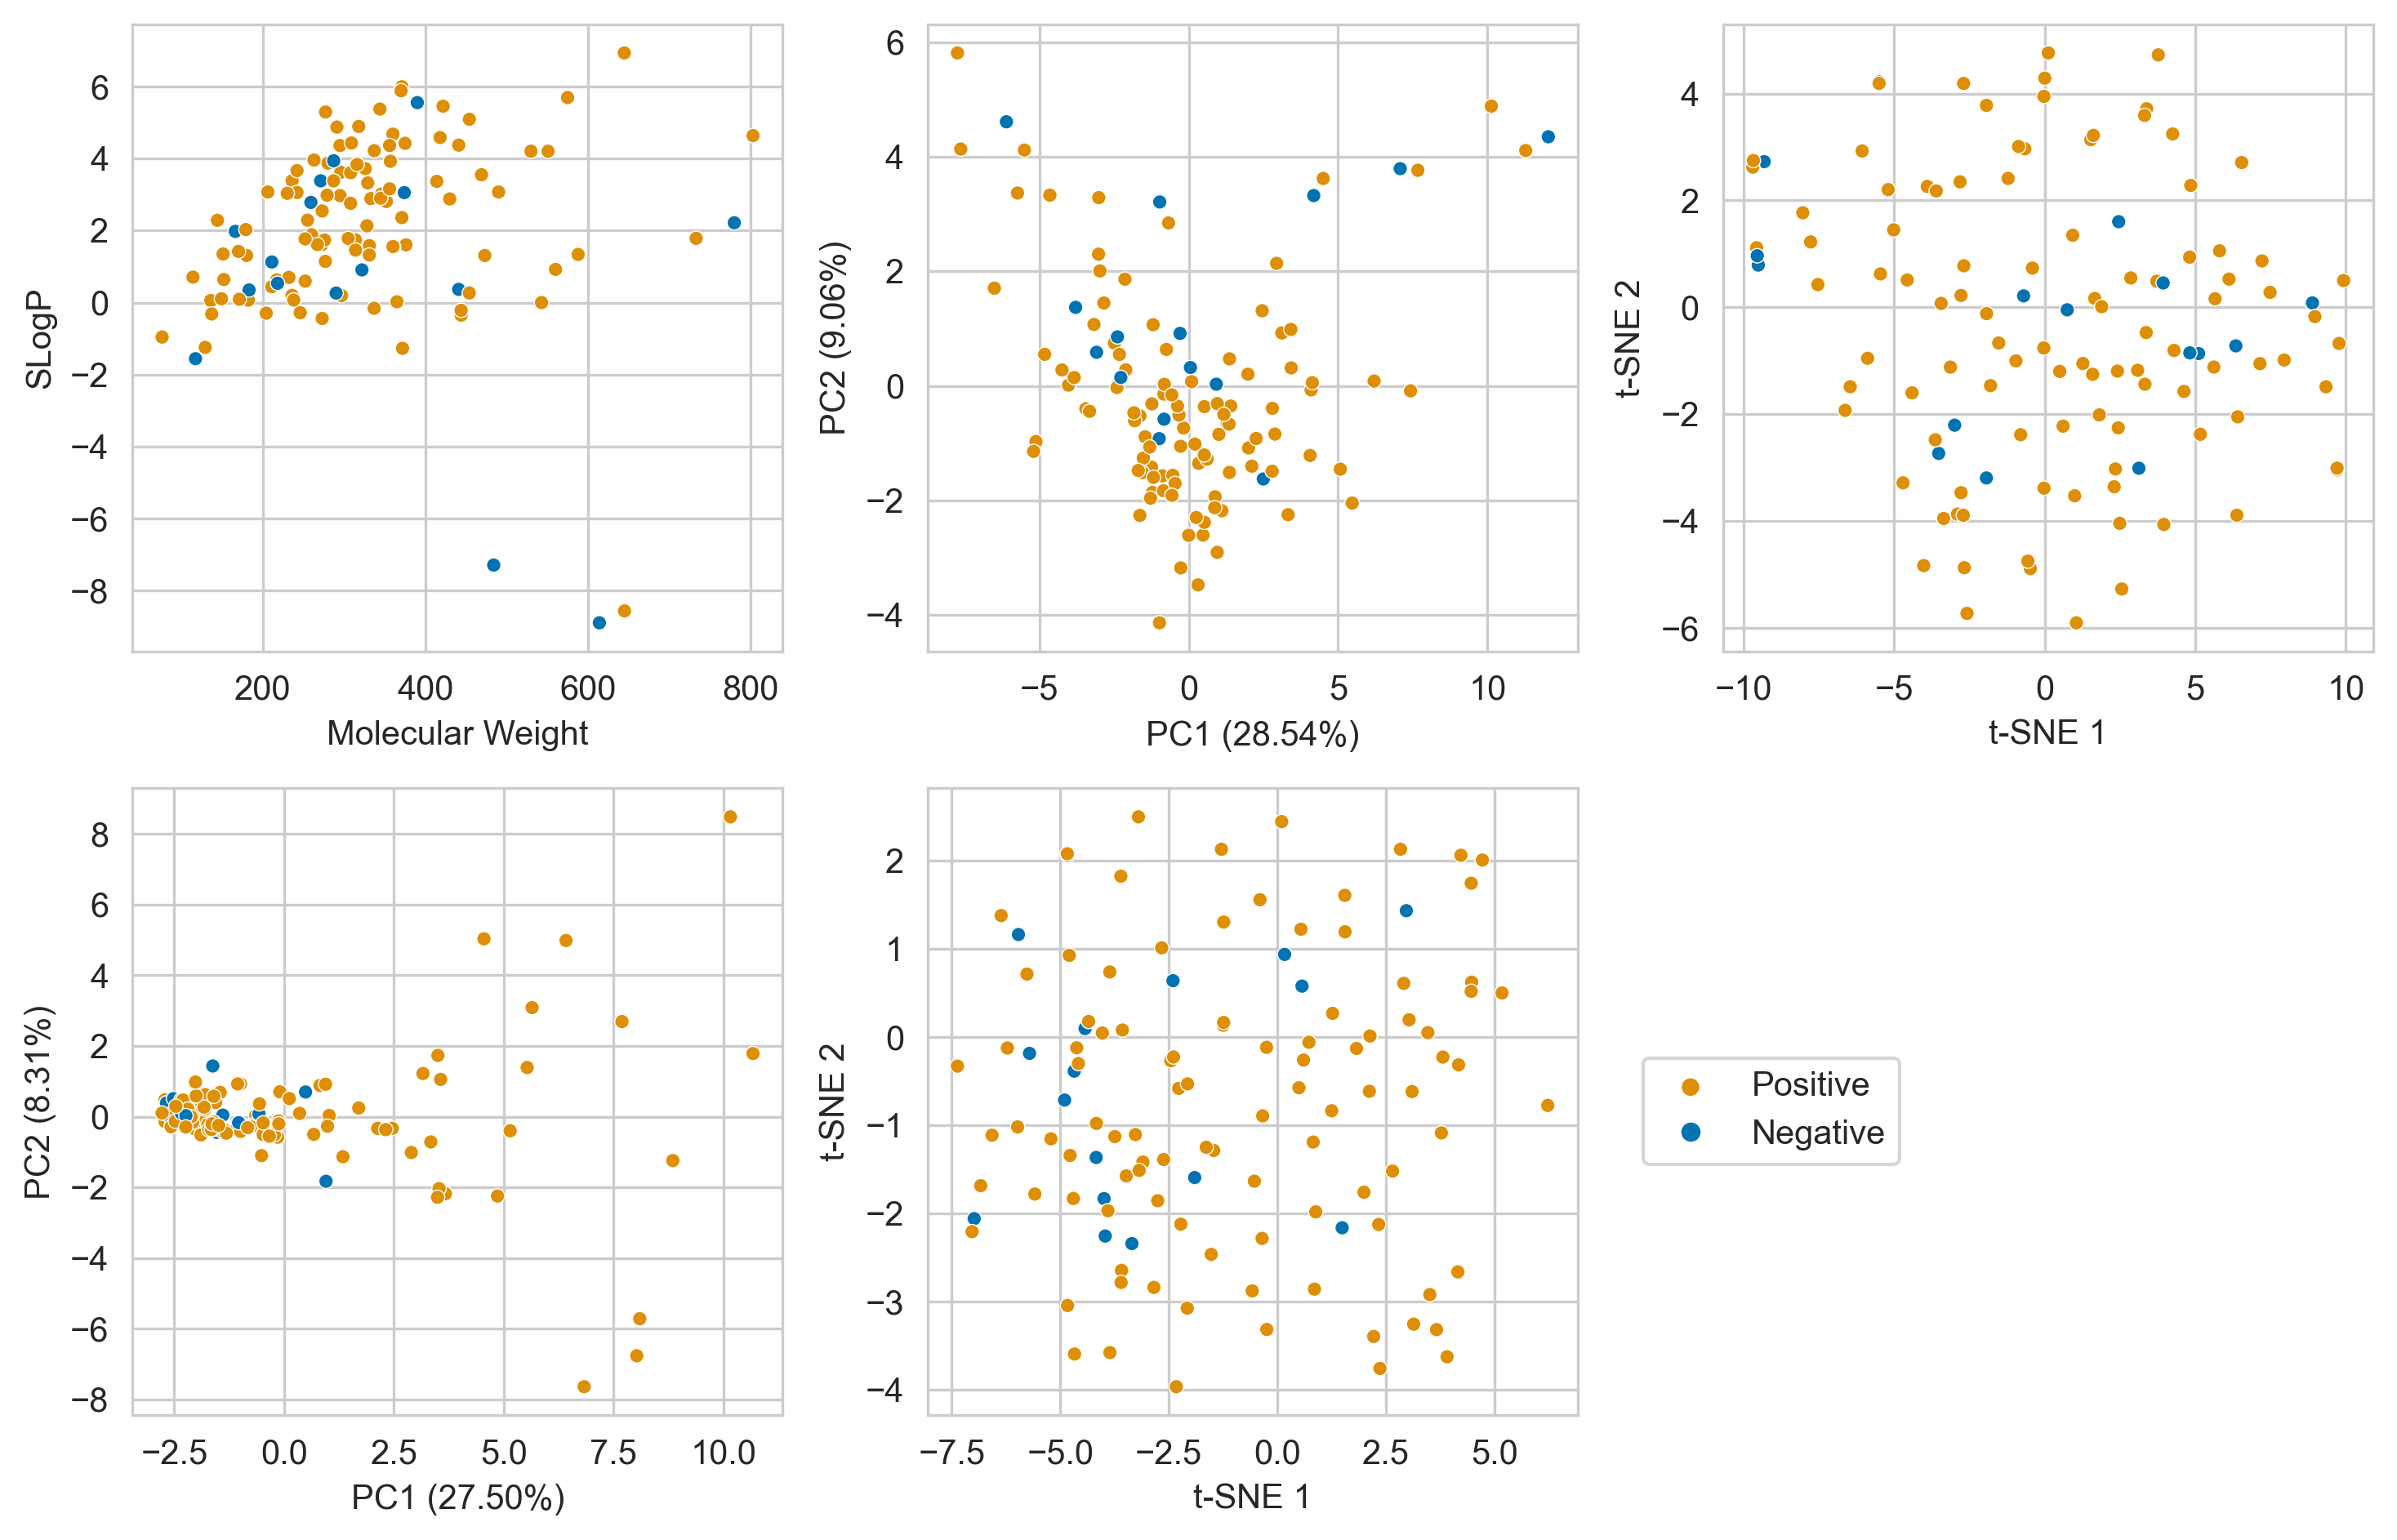

In [30]:
fig = plt.figure(dpi=300, figsize=(10, 6))
gs = fig.add_gridspec(2, 3)

with sns.axes_style("whitegrid"):
    sns.set_palette("colorblind")
    ax = fig.add_subplot(gs[0, 0])
    sns.scatterplot(y='SLogP', x='MW', color=sns.color_palette()[0],
                    data=data_moldescs, 
                    hue=data_mol['binaryDILI'],
                    size=[1] * data_molbio_tsne.shape[0],
                    ax=ax)
    ax.set(xlabel='Molecular Weight',
           ylabel=f'SLogP')
    plt.legend([],[], frameon=False)

with sns.axes_style("whitegrid"):
    sns.set_palette("colorblind")
    ax = fig.add_subplot(gs[0, 1])
    sns.scatterplot(x='PC1', y='PC2', color=sns.color_palette()[0],
                    data=data_moldescs_pca, 
                    size=[1] * data_molbio_tsne.shape[0],
                    hue='binaryDILI',
                    ax=ax)
    ax.set(xlabel=f'PC1 ({pca_mol.named_steps["pca"].explained_variance_ratio_[0]:.2%})',
           ylabel=f'PC2 ({pca_mol.named_steps["pca"].explained_variance_ratio_[1]:.2%})')
    plt.legend([],[], frameon=False)

with sns.axes_style("whitegrid"):
    sns.set_palette("colorblind")
    ax = fig.add_subplot(gs[0, 2])
    sns.scatterplot(x='t-SNE 1', y='t-SNE 2', color=sns.color_palette()[0],
                    data=data_moldescs_tsne, 
                    hue='binaryDILI',
                    size=[1] * data_molbio_tsne.shape[0],
                    ax=ax)
    plt.legend([],[], frameon=False)
    plt.tight_layout()

with sns.axes_style("whitegrid"):
    sns.set_palette("colorblind")
    ax = fig.add_subplot(gs[1, 0])
    sns.scatterplot(x='PC1', y='PC2', color=sns.color_palette()[0],
                    data=data_molbio_pca, 
                    hue='binaryDILI',
                    size=[1] * data_molbio_tsne.shape[0],
                    ax=ax)
    ax.set(xlabel=f'PC1 ({pca_bio.named_steps["pca"].explained_variance_ratio_[0]:.2%})',
           ylabel=f'PC2 ({pca_bio.named_steps["pca"].explained_variance_ratio_[1]:.2%})')
    plt.legend([],[], frameon=False)

with sns.axes_style("whitegrid"):
    sns.set_palette("colorblind")
    ax = fig.add_subplot(gs[1, 1])
    sns.scatterplot(x='t-SNE 1', y='t-SNE 2', color=sns.color_palette()[0],
                    data=data_molbio_tsne, 
                    hue='binaryDILI',
                    size=[1] * data_molbio_tsne.shape[0],
                    ax=ax)
    lgd = plt.legend(title='',
                     labels=['Positive', 'Negative'],
                     bbox_to_anchor=(1.1, 0.57),
                     loc=2,
                     borderaxespad=0.)
    lgd.legend_handles[0]._sizes = [30]
    lgd.legend_handles[1]._sizes = [17]

Obtain similarity heatmaps.
Choose either Pipeline Pilot (same as in Supp. Fig 1), or RDKit's implementation (slight variations).

In [31]:
LOAD_FROM = 'pipeline-pilot'  # Replace by 'rdkit' to get the RDKit's generated fingerprints' heatmap.

In [32]:
data = pd.read_excel(FILE, sheet_name='Original Dataset MolDescs', usecols=['InChIKey', 'SMILES'], engine='openpyxl')
names = pd.read_excel(FILE, sheet_name=0, usecols=['Name', 'InChIKey'])
names['Name'] = names.Name.str.lower()

data = data.merge(names, on='InChIKey')

Use the same order as in Figure 1.

In [33]:
if not os.path.exists(f'{OUT_FOLDER}/Heatmap_molecule_order.json'):
    raise ValueError(f'The file containing the order of molecules is absent. Please run the `Heatmap_biological_features.py` file or ensure the json it creates is stored under {os.path.abspath(OUT_FOLDER)}')
with open(f'{OUT_FOLDER}/Heatmap_molecule_order.json') as fh:
    order = list(chain.from_iterable(json.load(fh)))

In [34]:
# Keep only the compounds in Figure 1.
data = data[data.Name.isin(order)]
# Set the order
data['Name'] = data.Name.astype("category")
data['Name'] = data.Name.cat.set_categories(order)
data = data.sort_values(['Name'])

In [35]:
if LOAD_FROM == 'rdkit':
    ecfp6 = (data.SMILES
                 .apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=3, nBits=2048))
                 .tolist())
    fcfp6 = (data.SMILES
                 .apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=3, nBits=2048, useFeatures=True))
                 .tolist())
elif LOAD_FROM == 'pipeline-pilot':
    fps = pd.read_csv(f'{DATA_FOLDER}/DILI_dataset_ECFP6_FCFP6.tsv', sep='\t')
    ecfp6 = data[['InChIKey']].merge(fps, on='InChIKey')['ECFP_6'].apply(CreateFromBitString)
    fcfp6 = data[['InChIKey']].merge(fps, on='InChIKey')['FCFP_6'].apply(CreateFromBitString)
else:
    raise NotImplementedError(f'Fingerprints of this sort are not available: {LOAD_FROM}.')

In [36]:
tanimoto_ecfp6 = [[1 - x for x in BulkTanimotoSimilarity(fp, ecfp6)] for fp in ecfp6]
tanimoto_fcfp6 = [[1 - x for x in BulkTanimotoSimilarity(fp, fcfp6)] for fp in fcfp6]

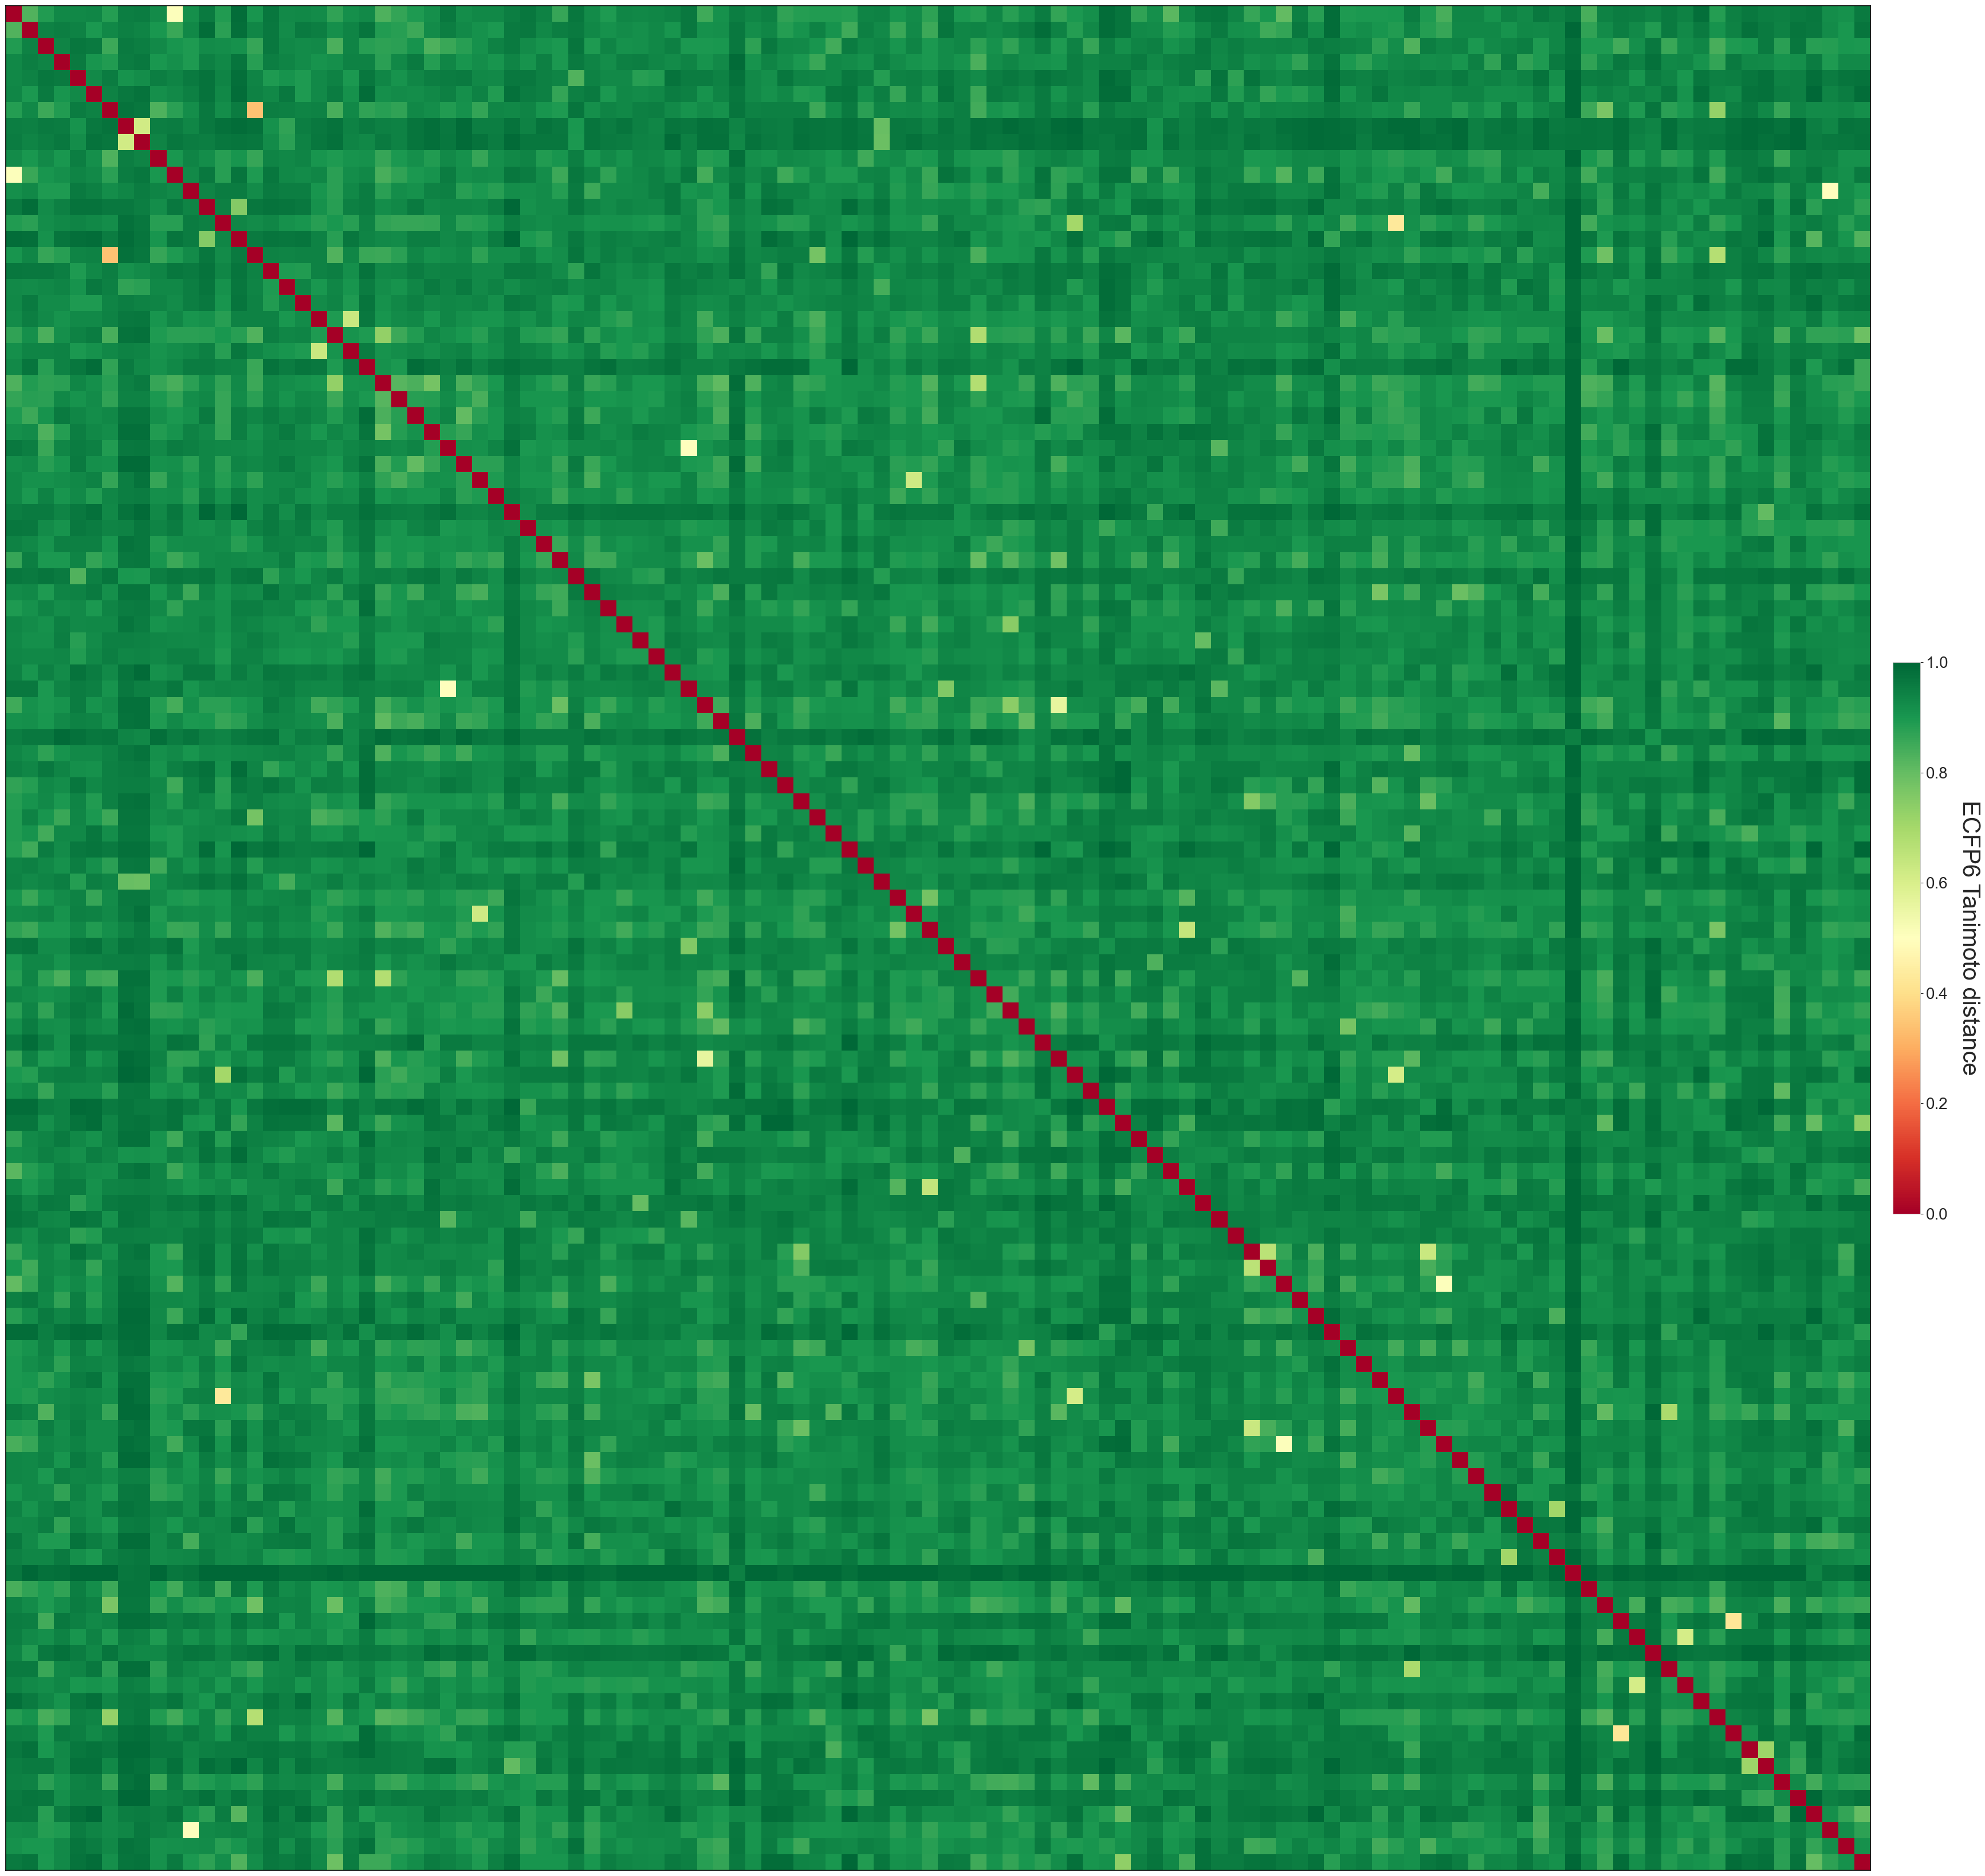

In [37]:
cmap = plt.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(50,50))
im = ax.matshow(tanimoto_ecfp6, interpolation=None, cmap=cmap, vmin=0.0, vmax=1.0, aspect='equal')
ax.tick_params(length=15, width=1.2)
plt.title('')

cbar = fig.colorbar(im, shrink=0.25, fraction=0.15, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('ECFP6 Tanimoto distance\n\n', rotation=270, labelpad=40)
cbar.ax.yaxis.label.set_size(30)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.set_xticks([], minor=False)
ax.set_yticks([], minor=False)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)

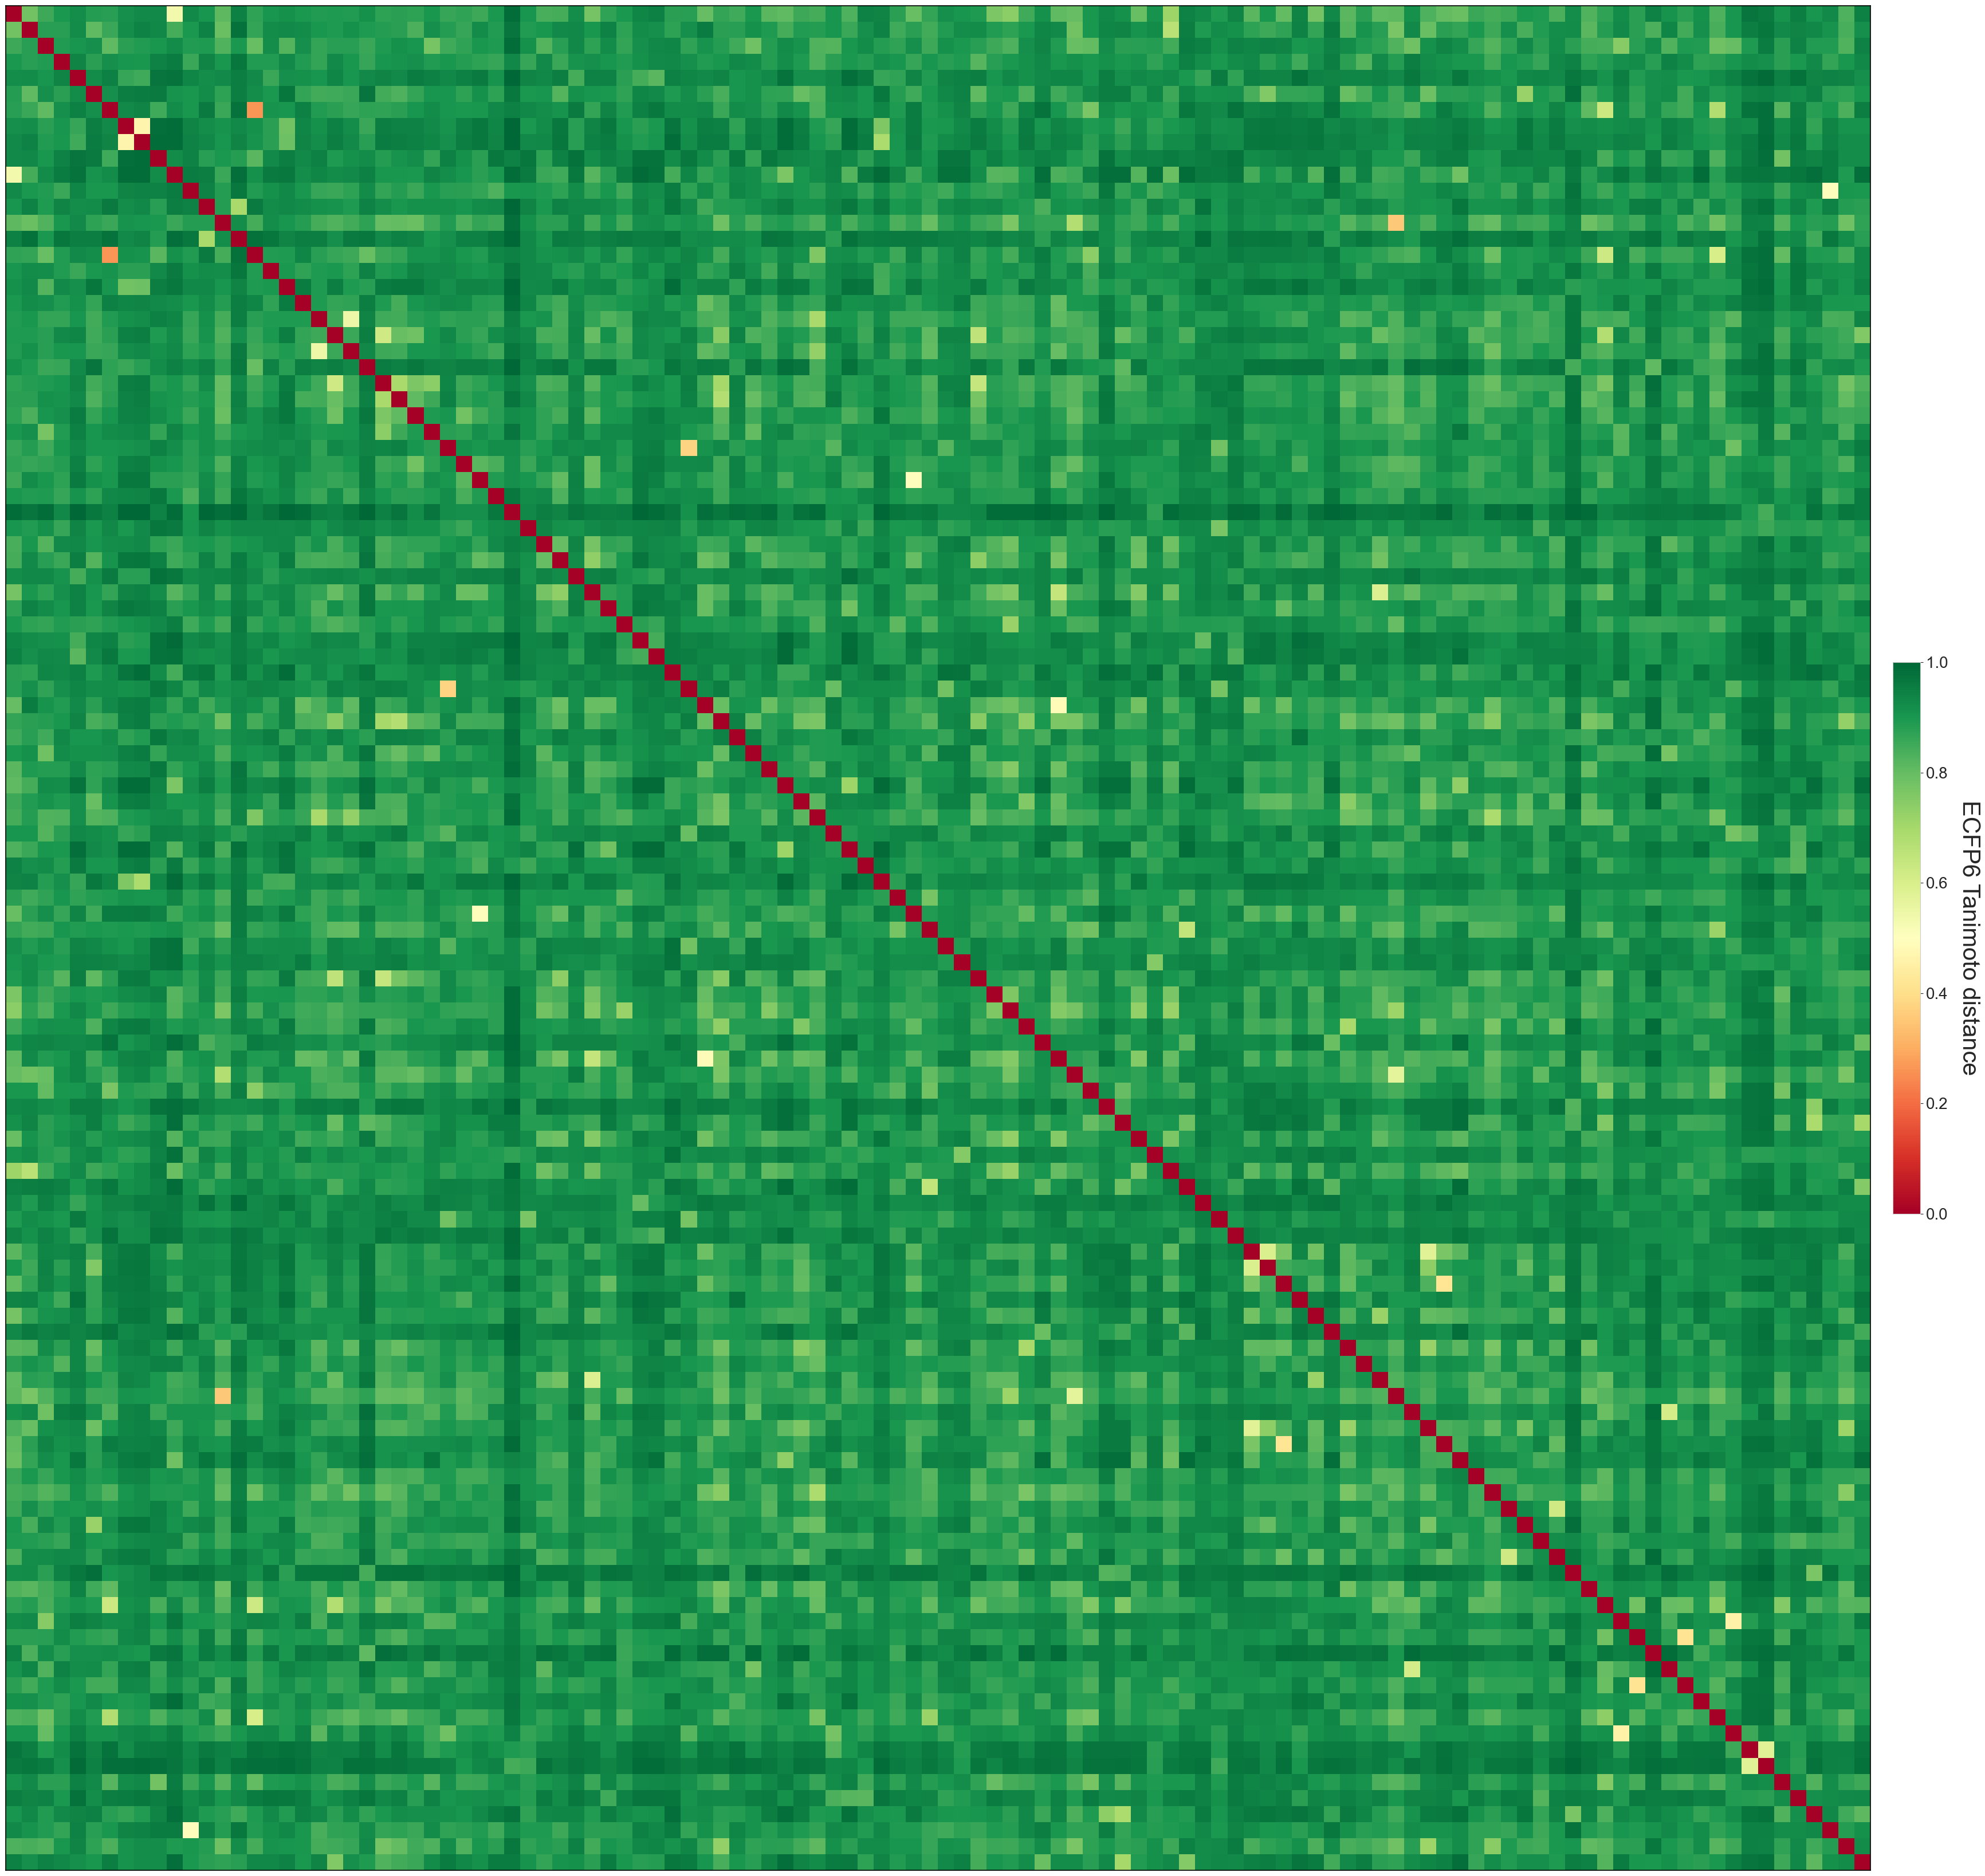

In [38]:
cmap = plt.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(50,50))
im = ax.matshow(tanimoto_fcfp6, interpolation=None, cmap=cmap, vmin=0.0, vmax=1.0, aspect='equal')
ax.tick_params(length=15, width=1.2)
plt.title('')

cbar = fig.colorbar(im, shrink=0.25, fraction=0.15, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('ECFP6 Tanimoto distance\n\n', rotation=270, labelpad=40)
cbar.ax.yaxis.label.set_size(30)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.set_xticks([], minor=False)
ax.set_yticks([], minor=False)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)